<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

In [71]:
import  os
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
import  statsmodels.api                             as      sm
from    time                                        import  time
from    scipy.stats                                 import  norm
from    scipy.special                               import  eval_genlaguerre
from    sklearn.linear_model                        import  LinearRegression, Ridge, HuberRegressor
from    statsmodels.nonparametric.kernel_regression import  KernelReg

np.random.seed(0)
plt.style.use('ggplot')

In [72]:
color_jlsmc     = 'blue'
color_invalid   = 'purple'

In [73]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
tref        = 1/12 # 1/12 : 1 month
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
Sref        = 100 # 100
alpha       = 0.99
K           = 95
order_mom   = 4

jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

In [74]:
def beta(t):
    return np.exp(-r*t)

def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

def gen_mtm_put(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

def get_mu2(mu1raw, mu2raw):
    return mu2raw - mu1raw**2
def get_mu3(mu1raw, mu2raw, mu3raw):
    return mu3raw - 3*mu1raw*mu2raw - mu1raw**3
def get_mu4(mu1raw, mu2raw, mu3raw, mu4raw):
    return mu4raw - 4*mu1raw*mu3raw + 6*mu2raw*mu1raw**2 - 3*mu1raw**4
def get_centred_moms(mu1raw, mu2raw, mu3raw, mu4raw):
    mu2 = get_mu2(mu1raw, mu2raw)
    mu3 = get_mu3(mu1raw, mu2raw, mu3raw)
    mu4 = get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    return mu2, mu3, mu4
def get_skew(mu3, mu2):
    return mu3 / mu2**(3/2)
def get_kurt(mu4, mu2):
    return mu4 / mu2**2


def regress_moms_jlsmc(mtm_train, y_train, mtm_pred_list, setting):
    start = time()
    method          = setting['method']
    yhat_pred_list  = []
    X_pred_list     = []
    for mtm in mtm_pred_list:
        yhat_pred   = np.zeros((len(mtm), order_mom+1))
        yhat_pred_list.append(yhat_pred)
    if (method == 'LR') or (method == 'HR') or (method == 'GLM'):
        S       = setting['S']
        X_train = np.column_stack([eval_genlaguerre(s, 0, mtm_train) for s in range(S+1)])
        for mtm in mtm_pred_list:
            X_pred = np.column_stack([eval_genlaguerre(s, 0, mtm) for s in range(S+1)])
            X_pred_list.append(X_pred)
        for j in range(1, order_mom+1):
            if j%2 != 0:
                if (method == 'LR') and (setting['ridge']>0):
                    model = Ridge(setting['ridge'], fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=setting['epsilon'], alpha=setting['ridge'], fit_intercept=False)
                elif (method == 'LR') or (method == 'GLM'):
                    model = LinearRegression(fit_intercept=False)
                
                model.fit(X_train, y_train[:, j-1])
            else:
                if (method == 'LR') and (setting['ridge']>0):
                    model = Ridge(alpha=setting['ridge'], fit_intercept=False)
                elif method == 'LR':
                    model = LinearRegression(fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=setting['epsilon'], alpha=setting['ridge'] ,fit_intercept=False)
                elif (method == 'GLM') and (setting['ridge']>0):
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.Log())).fit_regularized(method='elastic_net', alpha=setting['ridge'], L1_wt=0)
                elif method == 'GLM':
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
                
                if method != 'GLM':
                    model.fit(X_train, y_train[:, j-1])

            for i, mtm in enumerate(mtm_pred_list):
                yhat_pred_list[i][:, j-1] = model.predict(X_pred_list[i])
    
    elif method =='KR':

        X_train = mtm_train.reshape(-1, 1)
        iqr     = np.quantile(mtm_train, 0.75) - np.quantile(mtm_train, 0.25)
        slvm    = 0.9*min(np.std(mtm_train), iqr/1.34) * len(mtm_train)**(-1/5)
        for j in range(1, order_mom+1):
            kr                  = KernelReg(endog=y_train[:, j-1], exog=X_train, var_type='c', bw=[slvm])
            for i, mtm in enumerate(mtm_pred_list):
                X_pred          = mtm.reshape(-1, 1)
                yhat_pred_list[i][:, j-1] = kr.fit(X_pred)[0]
    end = time()
    
    return yhat_pred_list, end-start


def get_moms_mask(yhat):
    mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat = yhat[:, 0], yhat[:, 1], yhat[:, 2], yhat[:, 3]
    mu2hat, mu3hat, mu4hat  = get_centred_moms(mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat)
    skewhat                 = get_skew(mu3hat, mu2hat)
    kurthat                 = get_kurt(mu4hat, mu2hat)

    mask_mu2hat     = (mu2rawhat>0)&(mu2hat>0)
    mask_mu3hat     = (mu2rawhat>0)
    mask_mu4hat     = (mu4rawhat>0)&(mu2rawhat>0)&(mu4hat>0)
    mask_skewhat    = (mask_mu3hat)&(mask_mu2hat)
    mask_kurthat    = (mask_mu4hat)&(mask_mu2hat)
    mask_tothat     = (mask_skewhat)&(mask_kurthat)
    
    return mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat, mu2hat, mu3hat, mu4hat, skewhat, kurthat, mask_mu2hat, mask_mu3hat, mask_mu4hat, mask_skewhat, mask_kurthat, mask_tothat


def get_moms_nmc(M, M_in, S):
    S_paths_nested      = np.zeros((M, M_in, ind_tdelta-ind_tref+1))
    mtm_paths_nested    = np.zeros((M, M_in, ind_tdelta-ind_tref+1))
    mtmdiff            = np.zeros((M, M_in))
    for m in range(M):
        S_paths_nested[m, :, :]     = gen_S(S[m], M_in, ind_tdelta-ind_tref)
        mtm_paths_nested[m, :, :]   = gen_mtm_put(S_paths_nested[m, :, :], time_grid[ind_tref:ind_tdelta+1])
        mtmdiff[m, :]               = mtm_paths_nested[m, :, -1] - mtm_paths_nested[m, :, 0]
    
    mu1raw = np.mean(mtmdiff, axis=1)
    mu2raw = np.mean(mtmdiff**2, axis=1)
    mu3raw = np.mean(mtmdiff**3, axis=1)
    mu4raw = np.mean(mtmdiff**4, axis=1)
    mu2, mu3, mu4 = get_mu2(mu1raw, mu2raw), get_mu3(mu1raw, mu2raw, mu3raw), get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    skew     = get_skew(mu3, mu2)
    kurt     = get_kurt(mu4, mu2)

    return mtm_paths_nested, mtmdiff, mu1raw, mu2raw, mu3raw, mu4raw, mu2, mu3, mu4, skew, kurt

In [75]:
S_paths         = gen_S(S0, M, N)
mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtmdiff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
mtm_train       = mtm_paths[:, ind_tref]

mtm_func        = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000)

Nq          = 100
Nqtail      = int(0.1*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
mtm_supp    = np.quantile(mtm_train, q_all, method='inverted_cdf')

Mtest       = 100
Mtest_in    = 100000
S_test      = np.linspace(np.min(S_paths[:, ind_tref]), np.max(S_paths[:, ind_tref]), Mtest)
mtm_test_paths_nested, mtmdiff_test, mu1raw_test, mu2raw_test, mu3raw_test, mu4raw_test, mu2_test, mu3_test, mu4_test, skew_test, kurt_test = get_moms_nmc(Mtest, Mtest_in, S_test)
mtm_test    = mtm_test_paths_nested[:, 0, 0]

In [76]:
settings_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'S': 2},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'S': 4},
    {'id': 2, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'S': 2},
    {'id': 3, 'method': 'GLM', 'ridge': 0, 'S': 2},
    {'id': 4, 'method': 'GLM', 'ridge': 0, 'S': 4},
    {'id': 5, 'method': 'KR'}
]

for setting in settings_list:
    fpath = f'figures/{setting['id']}'
    os.makedirs(fpath, exist_ok=True)

setting = settings_list[5]

In [77]:
mtm_pred_list_jlsmc = [mtm_test, mtm_func, mtm_supp]
y_train_jlsmc = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_mom+1)
y_train_glsmc = mtmdiff_paths[:, ind_tref]**2

yhat_pred_list_jlsmc, time_jlsmc = regress_moms_jlsmc(mtm_train, y_train_jlsmc, mtm_pred_list_jlsmc, setting)
print(f"Time taken for moments regression: {time_jlsmc:.2f} seconds")

mu1rawhat_test_jlsmc, mu2rawhat_test_jlsmc, mu3rawhat_test_jlsmc, mu4rawhat_test_jlsmc, mu2hat_test_jlsmc, mu3hat_test_jlsmc, mu4hat_test_jlsmc, skewhat_test_jlsmc, kurthat_test_jlsmc, mask_mu2hat_test_jlsmc, mask_mu3hat_test_jlsmc, mask_mu4hat_test_jlsmc, mask_skewhat_test_jlsmc, mask_kurthat_test_jlsmc, mask_tothat_test_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[0])
mu1rawhat_func_jlsmc, mu2rawhat_func_jlsmc, mu3rawhat_func_jlsmc, mu4rawhat_func_jlsmc, mu2hat_func_jlsmc, mu3hat_func_jlsmc, mu4hat_func_jlsmc, skewhat_func_jlsmc, kurthat_func_jlsmc, mask_mu2hat_func_jlsmc, mask_mu3hat_func_jlsmc, mask_mu4hat_func_jlsmc, mask_skewhat_func_jlsmc, mask_kurthat_func_jlsmc, mask_tothat_func_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[1])
mu1rawhat_supp_jlsmc, mu2rawhat_supp_jlsmc, mu3rawhat_supp_jlsmc, mu4rawhat_supp_jlsmc, mu2hat_supp_jlsmc, mu3hat_supp_jlsmc, mu4hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_mu2hat_supp_jlsmc, mask_mu3hat_supp_jlsmc, mask_mu4hat_supp_jlsmc, mask_skewhat_supp_jlsmc, mask_kurthat_supp_jlsmc, mask_tothat_supp_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[2])

Time taken for moments regression: 83.77 seconds


C:\Users\CF518AW\AppData\Local\Temp\ipykernel_24852\679956231.py:35: RuntimeWarning: invalid value encountered in power
  return mu3 / mu2**(3/2)


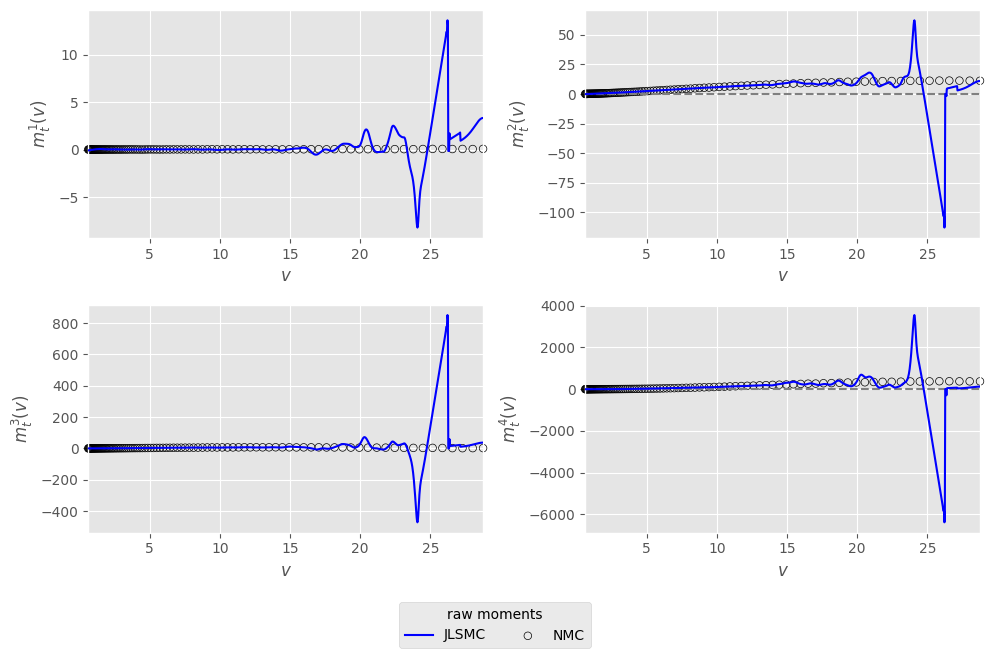

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, mu1rawhat_func_jlsmc, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$m_t^1(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, mu2rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[0, 1].scatter(mtm_test, mu2raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$m_t^2(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, mu3rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 0].scatter(mtm_test, mu3raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$m_t^3(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, mu4rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 1].scatter(mtm_test, mu4raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$m_t^4(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
#plt.savefig(f'figures/{setting['id']}/raw_moms.png', dpi=300, bbox_inches='tight')
plt.show()

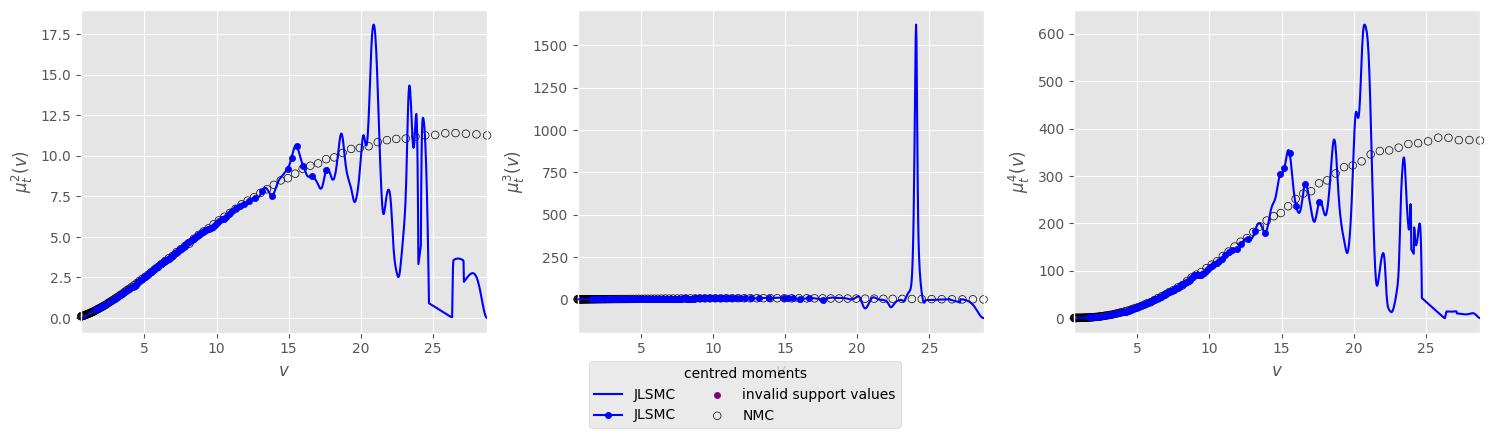

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[mask_mu2hat_func_jlsmc], mu2hat_func_jlsmc[mask_mu2hat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_mu2hat_supp_jlsmc], mu2hat_supp_jlsmc[mask_mu2hat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_mu2hat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_mu2hat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\mu_t^2(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_mu3hat_func_jlsmc], mu3hat_func_jlsmc[mask_mu3hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_mu3hat_supp_jlsmc], mu3hat_supp_jlsmc[mask_mu3hat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_mu3hat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_mu3hat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu3_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\mu_t^3(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_mu4hat_func_jlsmc], mu4hat_func_jlsmc[mask_mu4hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].scatter(mtm_supp[mask_mu4hat_supp_jlsmc], mu4hat_supp_jlsmc[mask_mu4hat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~mask_mu4hat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_mu4hat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[2].scatter(mtm_test, mu4_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\mu_t^4(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
#plt.savefig(f'figures/{setting['id']}/centred_moms.png', dpi=300, bbox_inches='tight')
plt.show()

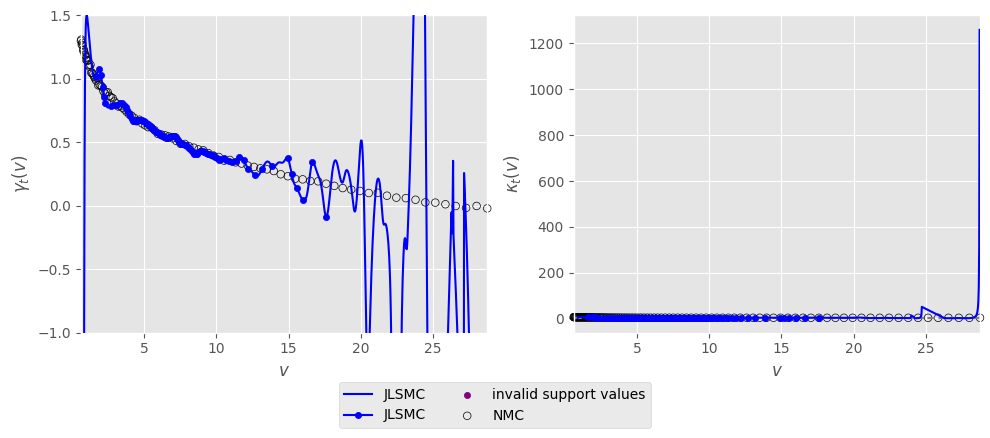

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_skewhat_func_jlsmc], skewhat_func_jlsmc[mask_skewhat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_skewhat_supp_jlsmc], skewhat_supp_jlsmc[mask_skewhat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_skewhat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_skewhat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1, top=1.5)

axs[1].plot(mtm_func[mask_kurthat_func_jlsmc], kurthat_func_jlsmc[mask_kurthat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_kurthat_supp_jlsmc], kurthat_supp_jlsmc[mask_kurthat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_kurthat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_kurthat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].axhline(0, color='grey', linestyle='--')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
#plt.savefig(f'figures/{setting['id']}/skew_kurt.png', dpi=300, bbox_inches='tight')
plt.show()

Total nummber of invalid support points: 0


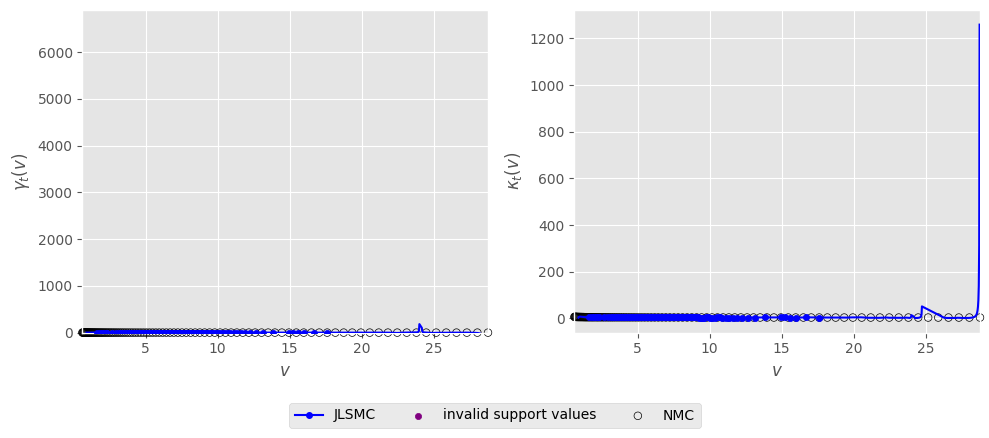

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp_jlsmc)}")

plt.tight_layout()
#plt.savefig(f'figures/{setting['id']}/skew_kurt_support.png', dpi=300, bbox_inches='tight')
plt.show()